First, the requirements are installed, the code of SAP-KG is imported, and some reoccurring variables are set:

In [36]:
pip install --no-cache-dir -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [37]:
import json
import operator
import itertools
from SPARQLWrapper import SPARQLWrapper, JSON
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

KGDBpedia = 'https://dbpedia.org/sparql'
KGWikidata = 'https://query.wikidata.org/sparql'

Here, the cardinality of triples with a specific predicate in Wikidata is retreived: 

In [38]:
def current_milli_time():
    return round(time.time() * 1000)


#Cardinality based on triple Wikidata
def query_generationWikidata(input_data, endpoint):
    query_select_clause = "SELECT (COUNT(?p) as ?count)"
    query_where_clause = """WHERE { ?s ?p ?o. """

    if "WikidataPredicate" in input_data["Input"]["IndependentVariables"]:
        query_where_clause = query_where_clause + """FILTER (?p IN( """ + input_data["Input"]["IndependentVariables"]["WikidataPredicate"] + ")) ."""

    query_where_clause = query_where_clause[:-1] + "}"
    sparqlQuery = query_select_clause + " " + query_where_clause
    # print(sparqlQuery)

    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    data = results["results"]["bindings"]
    print("Cardinality of triples with a predicate:",int(data[0]["count"]["value"]))
    

    return int(data[0]["count"]["value"])

Now, the cardinality of triples with the synonym of that predicate in DBpedia is retreived: 

In [39]:
#Cardinality based on triple DBpedia
def query_generationDBpedia(input_data, endpoint):
    query_select_clause = "SELECT COUNT(?p)"
    query_where_clause = """WHERE { ?s ?p ?o. ?s """

    if "DBpediaPredicate" in input_data["Input"]["IndependentVariables"]:
        query_where_clause = query_where_clause + "<" + input_data["Input"]["IndependentVariables"]["DBpediaPredicate"] + "> ?o" + ".\n"

    query_where_clause = query_where_clause + """FILTER (str(?p) IN (\"""" + input_data["Input"]["IndependentVariables"]["DBpediaPredicate"] + "\")) .}"""
    sparqlQuery = query_select_clause + " " + query_where_clause
    # print(sparqlQuery)

    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    data = results["results"]["bindings"]
    print("Cardinality of triples with the synonym predicate in other KG:", int(data[0]["callret-0"]["value"]))
    

    return int(data[0]["callret-0"]["value"])

The percentage of overlap of synonym predicates (POS) in a federation of knowledge graphs is as follows:

In [40]:
def computeMetricOverlapInter(input_file):
    random_id = str(current_milli_time())
    with open(input_file, "r") as input_file_descriptor:
        input_data = json.load(input_file_descriptor)
        countDBpedia = query_generationDBpedia(input_data, KGDBpedia)
        countWikidata = query_generationWikidata(input_data, KGWikidata)
        
        metric = round(float(min(countDBpedia, countWikidata) / max(countDBpedia, countWikidata)) * 100, 2)

        print("Percentage of Overlap-Synonym Inter:", metric)
        return 

if __name__ == '__main__':
    res = computeMetricOverlapInter("inputfilePredicateInter.json")

Cardinality of triples with the synonym predicate in other KG: 52303
Cardinality of triples with a predicate: 1647359
Percentage of Overlap-Synonym Inter: 3.17


The percentage of overlap of synonym predicates (POS) in a single knowledge graph is as follows:

In [41]:
#Cardinality based on triple Wikidata
def query_generationWikidata2(input_data, endpoint):
    query_select_clause = "SELECT (COUNT(?p) as ?count)"
    query_where_clause = """WHERE { ?s ?p ?o. """

    if "WikidataPredicate2" in input_data["Input"]["IndependentVariables"]:
        query_where_clause = query_where_clause + """FILTER (?p IN( """ + input_data["Input"]["IndependentVariables"]["WikidataPredicate2"] + ")) ."""

    query_where_clause = query_where_clause[:-1] + "}"
    sparqlQuery = query_select_clause + " " + query_where_clause
    # print(sparqlQuery)

    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    data = results["results"]["bindings"]
    print("Cardinality of triples with the synonym predicate in the same KG:", int(data[0]["count"]["value"]))
    

    return int(data[0]["count"]["value"])

In [42]:
def computeMetricOverlapIntra(input_file):
    random_id = str(current_milli_time())
    with open(input_file, "r") as input_file_descriptor:
        input_data = json.load(input_file_descriptor)
        countWikidata2 = query_generationWikidata2(input_data, KGWikidata)
        countWikidata = query_generationWikidata(input_data, KGWikidata)
        
        metric = round(float(min(countWikidata2, countWikidata) / max(countWikidata2, countWikidata)) * 100, 2)

        print("Percentage of Overlap-Synonym Intra:", metric)
        return 

if __name__ == '__main__':
    res = computeMetricOverlapIntra("inputfilePredicateIntra.json")

Cardinality of triples with the synonym predicate in the same KG: 638752
Cardinality of triples with a predicate: 46
Percentage of Overlap-Synonym Intra: 0.01


The low value of POS shows the low overlap between pair of synonym predicate candidates; therefore, the synonym prdicate candidates can be selected as the synonym predicates to complement each other in query rewriting process.

In [43]:
def query_expansion(query, property_to_replace, properties_to_add=[]):
    if type(query) is not str:
        raise TypeError('query must be string!')
    # add angle brackets to the endpoints of properties
    if property_to_replace[0] != '<':
        property_to_replace = '<' + property_to_replace + '>'
        properties_to_add = '<' + properties_to_add + '>'
        
    # for i in range(len(properties_to_add)):
        # properties_to_add[i] = '<' + properties_to_add[i] + '>'
    new_query = query
    
    part_within_braces = re.findall('\{.*\}', query, flags=re.DOTALL)[0]
    # for property in properties_to_add:
    new_query = new_query + '\nunion\n' + part_within_braces.replace(property_to_replace, properties_to_add)
    print(new_query)
    return new_query

In [49]:
def extract_property_from_query(query):
    return re.findall('<.*>', query)[-1][1:-1]

def query_rewriting():
    #source = request.args.get('source')
    #source = 'wikidata' if source is None else source
    with open('synonym-predicates.txt', 'rt') as f:
        add_properties = f.read()

    with open('Q1.txt', 'rt') as f:
        query = f.read()
    
    #add_properties = computeMetricOverlap(metric, extract_property_from_query(query))
    a = query_expansion(query, extract_property_from_query(query), add_properties)
    
    with open('Q1-rewritten.txt', 'wt') as f:
        f.write(a)

    
    return



if __name__ == '__main__':
    res = query_rewriting()

SELECT DISTINCT ?s1 ?o3 
WHERE {
{?s1 <wdt:P40> ?o.
?s1 <wdt:P509> ?o1.
?s1 <wdt:P19> ?o2.
?s1 <wdt:P8810> ?o3.}
}
union
{
{?s1 <wdt:P40> ?o.
?s1 <wdt:P509> ?o1.
?s1 <wdt:P19> ?o2.
?s1 <wdt:P25> ?o3.}
}


Ten queries over six domains (e.g., Film, Sport, Person, Drug, Music, History) that return incomplete results are selected. By rewriting these queries with the synonym predicates which complement each other, the complete answers are retrieved. The high value of precision shows the completeness of query answer after rewriting with synonym predicates compared with the queries without rewriting with synonym ones.

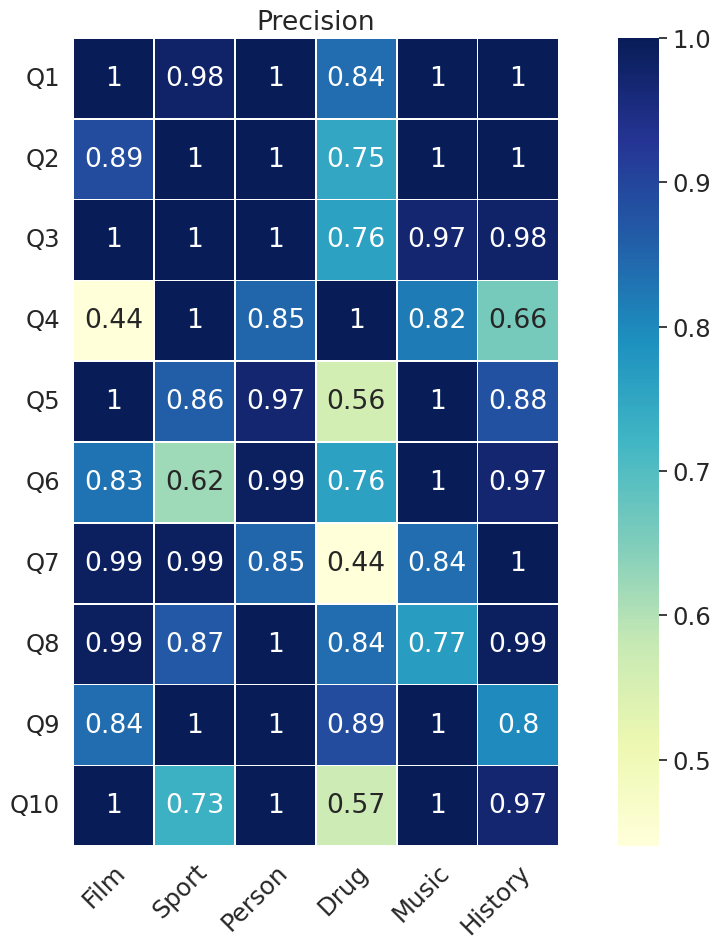

In [48]:
def precision(precision):
    precision = pd.read_csv("Precision-Recall/Precision.csv", index_col=0)
    cmap = sns.cm.rocket_r
    ax = sns.heatmap(precision, cmap = 'YlGnBu', linewidth=0.5, annot=precision)
    im = ax.imshow(precision)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    plt.setp(ax.get_yticklabels(), rotation=0,
             rotation_mode="anchor")
    # ax.set_title("")

    fig = plt.gcf()
    fig.set_size_inches(15.5, 10.5)

    plt.title('Precision')
    plt.savefig('Precision-Recall/Precision.png', dpi=100)
    plt.show()
    
precision(precision)

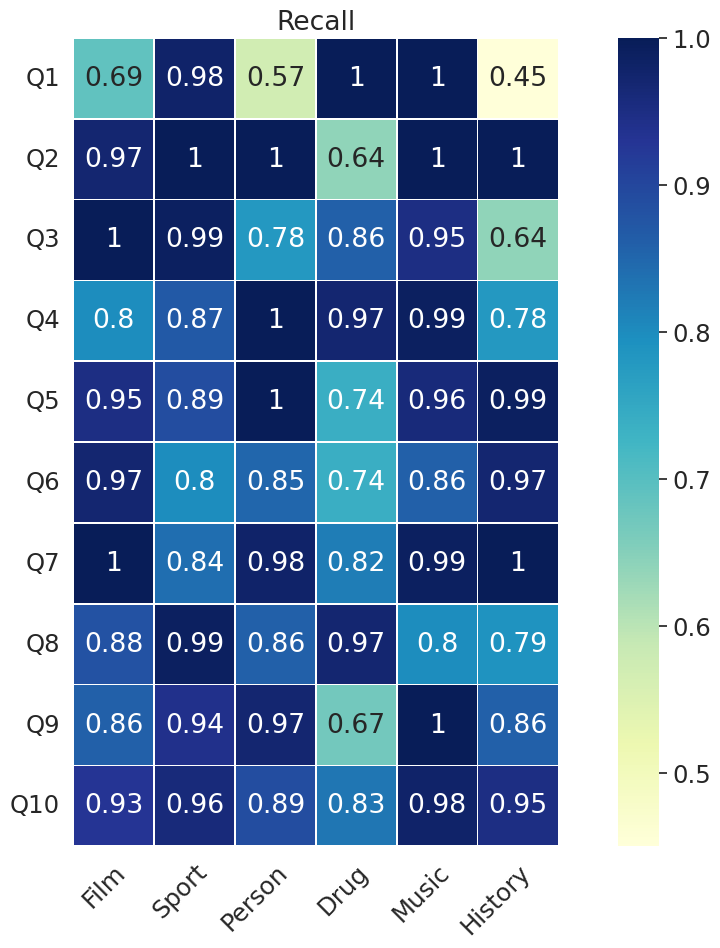

In [47]:
def recall(recall):
    recall = pd.read_csv("Precision-Recall/Recall.csv", index_col=0)
    cmap = sns.cm.rocket_r
    ax = sns.heatmap(recall, cmap = 'YlGnBu', linewidth=0.5, annot=recall)
    im = ax.imshow(recall)


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    plt.setp(ax.get_yticklabels(), rotation=0,
             rotation_mode="anchor")
    # ax.set_title("")

    fig = plt.gcf()
    fig.set_size_inches(15.5, 10.5)

    plt.title('Recall')
    plt.savefig('Precision-Recall/Recall.png', dpi=100)
    plt.show()
    
recall(recall)